# Introduction to Neural Networks and PyTorch

Eva Dyer & Mehdi Azabou
Georgia Tech (dyerlab.gatech.edu)
_____


**Important:** 

Before starting this notebook, enable GPU hardware accelerator, 
just go to Runtime -> Change runtime type -> Hardware accelerator -> GPU


### Loading data from MedMNIST.

We will be using the BreastMNIST dataset from [MedMNIST](https://medmnist.com/).
The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 2 classes: normal/benign and malignant. The source images of 1×500×500 are resized into 1×28×28.

In [1]:
!pip install --upgrade git+https://github.com/MedMNIST/MedMNIST.git --quiet

     |████████████████████████████████| 87 kB 4.6 MB/s 


In [2]:
from tqdm import tqdm
import numpy as np

import medmnist
from medmnist import INFO

data_flag = 'breastmnist'

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [3]:
# load the data
train_dataset = DataClass(split='train', download=True)
valid_dataset = DataClass(split='val', download=True)
test_dataset = DataClass(split='test', download=True)

  0%|          | 0/559580 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz


Dataset BreastMNIST (breastmnist)
    Number of datapoints: 546
    Root location: /root/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0 



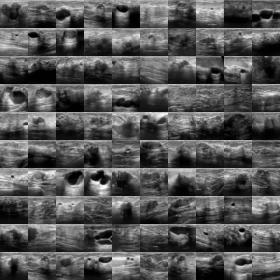

In [4]:
print(train_dataset, '\n')
train_dataset.montage(length=10)

# Multi-Layer Perceptron

[Tensorflow Playground](https://playground.tensorflow.org/#activation=relu&regularization=L2&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.01&regularizationRate=0.003&noise=0&networkShape=6,4,4,4,2&seed=0.69975&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)


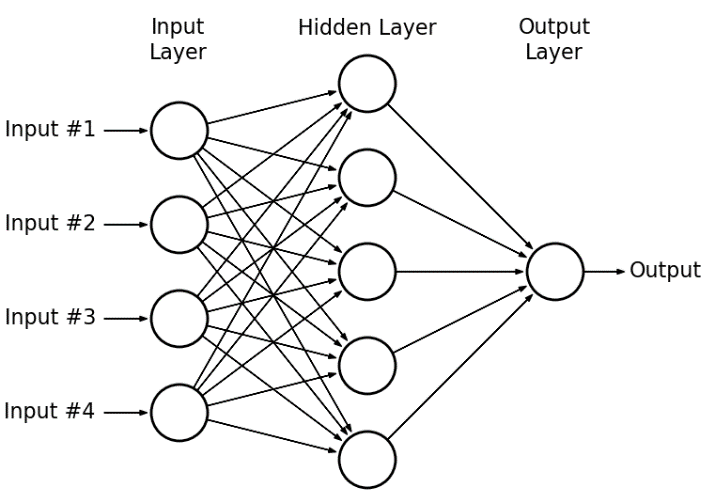


#### Training using `scikit-learn`
scikit-learn provides a simple MLP classifier. Read the documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html).

First we need to flatten the images into 1d vectors of size 28 x 28.

In [5]:
train_imgs = train_dataset.imgs.reshape(-1, 28 * 28)
train_labels = train_dataset.labels.squeeze()

test_imgs = test_dataset.imgs.reshape(-1, 28 * 28)
test_labels = test_dataset.labels.squeeze()

We make an `MLPClassifier` by specifying: 
- the number and sizes of the hidden layers (in addition to the input and output layers)
- The activation function [ReLU, Sigmoid, Tanh]
- The optimizer (or solver) [Adam, SGD, LBFGS]
- The batch size
- The learning rate

In [6]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=(512, 256, 64), activation='relu', solver='adam', batch_size=512, learning_rate_init=1e-5, max_iter=500)
clf.fit(train_imgs, train_labels)

print('Train accuracy:', clf.score(train_imgs, train_labels))
print('Test accuracy:', clf.score(test_imgs, test_labels))

Train accuracy: 1.0
Test accuracy: 0.7243589743589743


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


# Convolutional neural networks

Convolutions are the elementary operations used in CNNs. The image (and later, the feature maps) are convolved with multiple kernels which weights are learned. Below is a visual of the pixel values in the output matrix (green) being computed from neighboring pixels in the input matrix (blue).

![](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/full_padding_no_strides.gif)

#### Training using PyTorch

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
torch.manual_seed(104)

import matplotlib.pyplot as plt
import numpy as np

#### 1. Loading and normalizing the data

We define a `transform` function that transforms an image to a tensor (equivalent of a numpy array in PyTorch), and then normalizing the pixel values.

In [8]:
data_transform = transforms.Compose([
    transforms.ToTensor(), # rescales to 0,1
    transforms.Normalize(mean=[.5], std=[.5]) # (x- mu)/std 
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=True)
valid_dataset = DataClass(split='val', transform=data_transform, download=True)
test_dataset = DataClass(split='test', transform=data_transform, download=True)

Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz


#### 2. Defining dataloaders

During training, we feed a batch of images to the model. We thus define a `DataLoader` that builds these batches out of the data samples.

In [9]:
train_loader = data.DataLoader(train_dataset, batch_size=512, shuffle=True, drop_last=True) # drop last = if the last batch isn't equal to batch sz, drop it!
valid_loader = data.DataLoader(valid_dataset, batch_size=512, shuffle=False)
test_loader = data.DataLoader(test_dataset, batch_size=512, shuffle=False)

#### 3. Building our model

The model consists of two blocks: a CNN feature extractor and a fully-connected classifier.

The model predicts a value between 0 and 1 that represents the probability of the image being from the positive (1) or negative class (0).

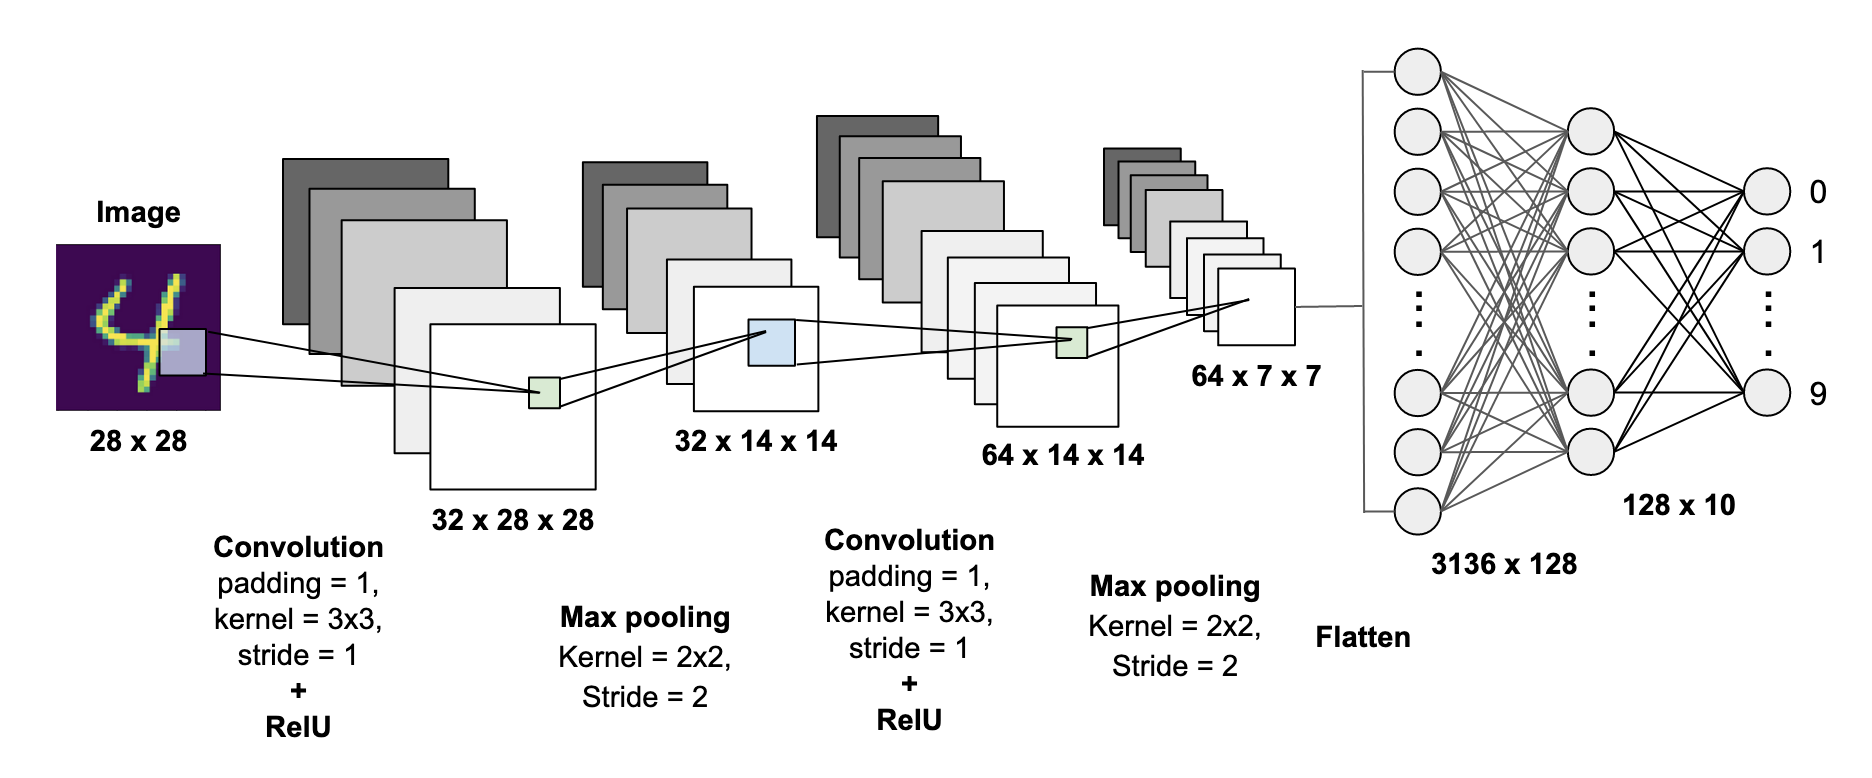

In [10]:
#  torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0) 
# torch.nn.MaxPool2d(kernel_size, stride=None)

def get_model():
  model = nn.Sequential(
      nn.Conv2d(1, 4, 3), 
      nn.ReLU(),
      
      nn.Conv2d(4, 8, 3), 
      nn.ReLU(),
      nn.MaxPool2d(2), 
      
      nn.Conv2d(8, 16, 3), 
      nn.ReLU(),
      nn.MaxPool2d(2), 

      nn.Flatten(),
      nn.Linear(400, 128),
      nn.ReLU(),
      nn.Linear(128, 1), # BCE loss = sigmoid + CE
  )
  return model

In [11]:
model = get_model()
print(model)

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=400, out_features=128, bias=True)
  (10): ReLU()
  (11): Linear(in_features=128, out_features=1, bias=True)
)


In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device);

#### 4. Defining the loss
Since this is a binary classification task, we can use the binary cross entropy loss. Given an image, the network will predict $p$, between $0$ and $1$ representing the probability that the image belongs to the positive class.
We compute the loss with respect to the ground truth label $y \in \{0, 1\}$.

$$
\mathrm{loss} = -(y \log(p)+(1−y)\log(1−p))
$$

In [13]:
criterion = nn.BCEWithLogitsLoss()

#### 5. Defining the optimizer 
The optimizer is responsible for updating the weights of the model in order to minimize the loss. The Adam optimizer is the recommended optimizer to use in most cases.

In [14]:
lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)

#### 6. Finally, we define the train and test functions

In [15]:
def train(model, train_loader):
    model.train()

    for inputs, targets in train_loader:
        # forward
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        
        targets = targets.to(torch.float32)
        loss = criterion(outputs, targets)
        
        # backward
        loss.backward()

        # optimize
        optimizer.step()

        # log history
        history['step_loss'].append(loss.item())

def test(model, loader):
    model.eval()
    loss = 0
    correct = 0

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            output = model(inputs)

            targets = targets.to(torch.float32)
            loss += F.binary_cross_entropy_with_logits(output, targets, reduction='sum').item()  # sum up batch loss
            pred = output >= 0
            correct += pred.eq(targets.view_as(pred)).sum().item()

    loss /= len(loader.dataset)
    return loss, 100. * correct / len(loader.dataset)


# Utilities
def plot_curves(history):
    fig, axes = plt.subplots(1, 2, figsize=(12,4))

    axes[0].plot(range(1, num_epochs+1), history['train_loss'])
    axes[0].plot(range(1, num_epochs+1), history['valid_loss'])
    axes[0].legend(['Train loss curve', 'Validation loss curve'])
    axes[0].set_xlabel('epoch')
    axes[0].set_ylabel('loss')


    axes[1].plot(range(1, num_epochs+1), history['train_acc'])
    axes[1].plot(range(1, num_epochs+1), history['valid_acc'])
    axes[1].legend(['Train accuracy curve', 'Validation accuracy curve'])
    axes[1].set_xlabel('epoch')
    axes[1].set_ylabel('accuracy')
    plt.show()


Now, we train the model for a number of epochs. 
An epoch is defined as a full pass over the training samples.

100%|██████████| 200/200 [00:50<00:00,  3.93it/s]


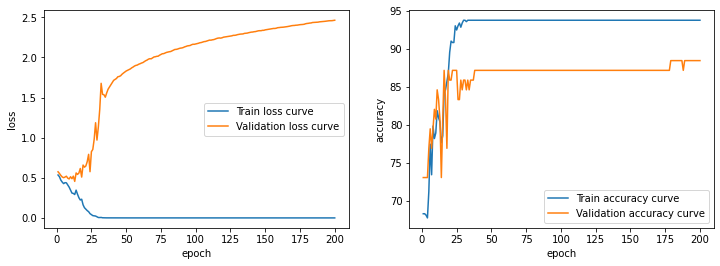

In [16]:
num_epochs = 200
lr = 1e-2
batch_size = 64

train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
model = get_model().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()

history = {'train_loss': [], 'train_acc': [], 
           'valid_loss': [], 'valid_acc': [],
           'test_loss': [], 'test_acc': [], 'step_loss': []}

for epoch in tqdm(range(1, num_epochs + 1)):
    train(model, train_loader)

    loss, acc = test(model, train_loader)
    history['train_loss'].append(loss)
    history['train_acc'].append(acc)

    loss, acc = test(model, valid_loader)
    history['valid_loss'].append(loss)
    history['valid_acc'].append(acc)

    loss, acc = test(model, test_loader)
    history['test_loss'].append(loss)
    history['test_acc'].append(acc)

plot_curves(history)

In [17]:
print('Train acc: %.2f' % history['train_acc'][-1])
print('Validation acc: %.2f' % history['valid_acc'][-1])
print('Test acc: %.2f' % history['test_acc'][-1])

Train acc: 93.77
Validation acc: 88.46
Test acc: 83.97


We notice that after a certain number of epochs, the validation loss starts increasing, this is an indication that the model is starting to overfit the training data.

### Understanding the learning rate:

At each training step, the weights of the model are updated following the gradient of the loss. The learning rate defines the how much to move along that gradient.

First, we try using a small learning rate, in which case we would expect the convergence to be extremly slow, as the optimizer take very small steps:

100%|██████████| 200/200 [00:44<00:00,  4.47it/s]


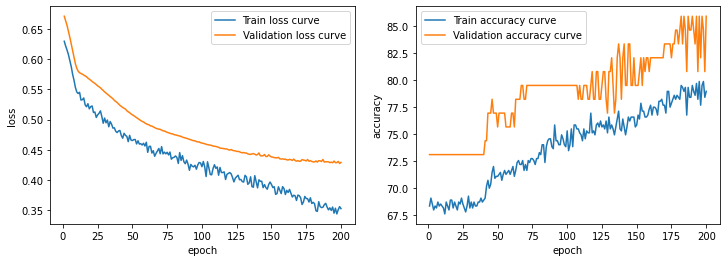

In [18]:
num_epochs = 200
lr = 1e-4
batch_size = 64

train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
model = get_model().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()

history = {'train_loss': [], 'train_acc': [], 
           'valid_loss': [], 'valid_acc': [],
           'test_loss': [], 'test_acc': [], 'step_loss': []}

for epoch in tqdm(range(1, num_epochs + 1)):
    train(model, train_loader)

    loss, acc = test(model, train_loader)
    history['train_loss'].append(loss)
    history['train_acc'].append(acc)

    loss, acc = test(model, valid_loader)
    history['valid_loss'].append(loss)
    history['valid_acc'].append(acc)

    loss, acc = test(model, test_loader)
    history['test_loss'].append(loss)
    history['test_acc'].append(acc)

plot_curves(history)

On the other hand, when we use a very high learning rate, the convergence is very noisy and unstable:

100%|██████████| 200/200 [00:46<00:00,  4.32it/s]


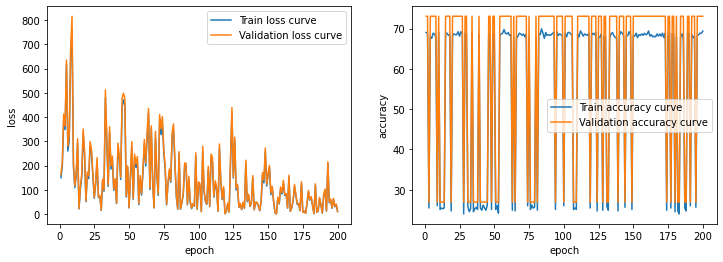

In [19]:
num_epochs = 200
lr = 10
batch_size = 64

train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
model = get_model().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()

history = {'train_loss': [], 'train_acc': [], 
           'valid_loss': [], 'valid_acc': [],
           'test_loss': [], 'test_acc': [], 'step_loss': []}

for epoch in tqdm(range(1, num_epochs + 1)):
    train(model, train_loader)

    loss, acc = test(model, train_loader)
    history['train_loss'].append(loss)
    history['train_acc'].append(acc)

    loss, acc = test(model, valid_loader)
    history['valid_loss'].append(loss)
    history['valid_acc'].append(acc)

    loss, acc = test(model, test_loader)
    history['test_loss'].append(loss)
    history['test_acc'].append(acc)

plot_curves(history)

### Understanding the influence of the batch size

When estimating the gradient, we use a batch of samples that is a small subset from the entire dataset. With a smaller batch, the approximated gradient becomes noisier. 

100%|██████████| 20/20 [00:08<00:00,  2.28it/s]


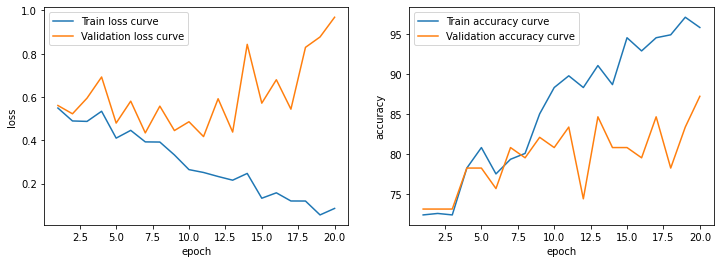

In [20]:
# Noisy gradient estimation (Only 2 examples per batch)
num_epochs = 20
lr = 1e-2
batch_size = 10

train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
model = get_model().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()

history = {'train_loss': [], 'train_acc': [], 
           'valid_loss': [], 'valid_acc': [],
           'test_loss': [], 'test_acc': [], 'step_loss': []}

for epoch in tqdm(range(1, num_epochs + 1)):
    train(model, train_loader)

    loss, acc = test(model, train_loader)
    history['train_loss'].append(loss)
    history['train_acc'].append(acc)

    loss, acc = test(model, valid_loader)
    history['valid_loss'].append(loss)
    history['valid_acc'].append(acc)

    loss, acc = test(model, test_loader)
    history['test_loss'].append(loss)
    history['test_acc'].append(acc)

plot_curves(history)

We can see this when we look at the loss value after each training step:

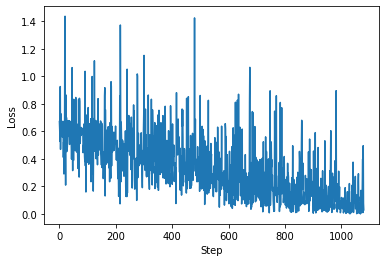

In [21]:
plt.plot(history['step_loss'])
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()


## How to regularize a neural network

Note how after a few epochs, the validation loss starts increasing, this is an indication that the model is overfitting.

There are multiple strategies to avoid overfitting.

#### 1. Early stopping

We can stop the model training once the validation curve starts increasing and diverging from the training curve.

100%|██████████| 200/200 [00:44<00:00,  4.46it/s]


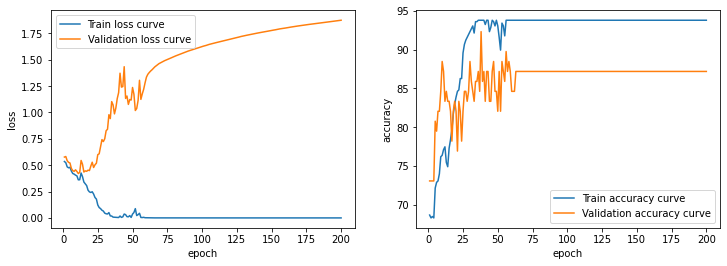

In [22]:
num_epochs = 200
lr = 1e-2
batch_size = 64

train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
model = get_model().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()

history = {'train_loss': [], 'train_acc': [], 
           'valid_loss': [], 'valid_acc': [],
           'test_loss': [], 'test_acc': [], 'step_loss': []}

for epoch in tqdm(range(1, num_epochs + 1)):
    train(model, train_loader)

    loss, acc = test(model, train_loader)
    history['train_loss'].append(loss)
    history['train_acc'].append(acc)

    loss, acc = test(model, valid_loader)
    history['valid_loss'].append(loss)
    history['valid_acc'].append(acc)

    loss, acc = test(model, test_loader)
    history['test_loss'].append(loss)
    history['test_acc'].append(acc)

plot_curves(history)

In [23]:
print('Accuracies of model at last epoch:')
print('Train acc: %.2f' % history['train_acc'][-1])
print('Validation acc: %.2f' % history['valid_acc'][-1])
print('Test acc: %.2f' % history['test_acc'][-1])

Accuracies of model at last epoch:
Train acc: 93.77
Validation acc: 87.18
Test acc: 77.56


In [24]:
early_stop_epoch = np.argmax(history['valid_acc'])
print('Train acc (Early stopping): %.2f' % history['train_acc'][early_stop_epoch])
print('Validation acc (Early stopping): %.2f' % history['valid_acc'][early_stop_epoch])
print('Test acc (Early stopping): %.2f' % history['test_acc'][early_stop_epoch])

Train acc (Early stopping): 93.77
Validation acc (Early stopping): 92.31
Test acc (Early stopping): 80.13


#### 2. Weight decay

Similar to the lasso regularization, we can add an L2-regularization term for the weights, which helps with the overfitting.

100%|██████████| 200/200 [00:44<00:00,  4.45it/s]


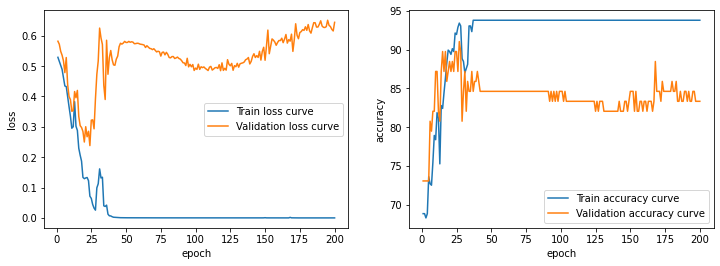

In [25]:
num_epochs = 200
lr = 1e-2
batch_size = 64
weight_decay = 1e-4

train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
model = get_model().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
criterion = nn.BCEWithLogitsLoss()

history = {'train_loss': [], 'train_acc': [], 
           'valid_loss': [], 'valid_acc': [],
           'test_loss': [], 'test_acc': [], 'step_loss': []}

for epoch in tqdm(range(1, num_epochs + 1)):
    train(model, train_loader)

    loss, acc = test(model, train_loader)
    history['train_loss'].append(loss)
    history['train_acc'].append(acc)

    loss, acc = test(model, valid_loader)
    history['valid_loss'].append(loss)
    history['valid_acc'].append(acc)

    loss, acc = test(model, test_loader)
    history['test_loss'].append(loss)
    history['test_acc'].append(acc)

plot_curves(history)

In [26]:
early_stop_epoch = np.argmax(history['valid_acc'])
print('Train acc (Early stopping): %.2f' % history['train_acc'][early_stop_epoch])
print('Validation acc (Early stopping): %.2f' % history['valid_acc'][early_stop_epoch])
print('Test acc (Early stopping): %.2f' % history['test_acc'][early_stop_epoch])

Train acc (Early stopping): 93.41
Validation acc (Early stopping): 91.03
Test acc (Early stopping): 84.62


#### 3. Network dropout
Another startegy for regularization is dropout, which is randomly setting a fraction of the network units to 0 at each training iteration. 

Dropout can be interpreted in various ways, such as randomly sampling from an exponential number of different networks. 

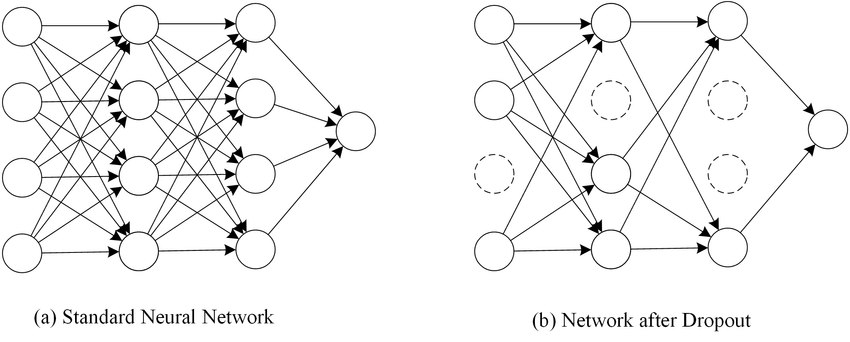

100%|██████████| 200/200 [00:45<00:00,  4.43it/s]


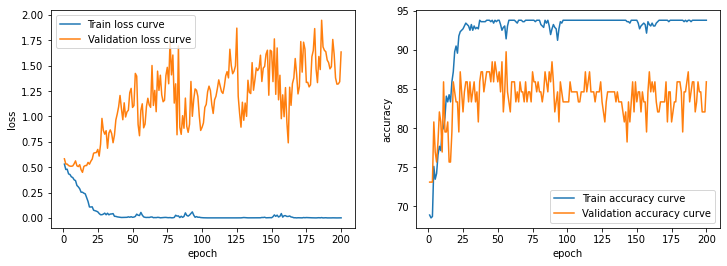

In [27]:
def get_model_with_dropout():
  model = nn.Sequential(
      nn.Conv2d(1, 8, 3), nn.ReLU(),
      nn.Conv2d(8, 8, 3), nn.ReLU(),
      nn.MaxPool2d(2), 
      nn.Conv2d(8, 16, 3), nn.ReLU(),
      nn.MaxPool2d(2), 
      nn.Flatten(),
      nn.Linear(400, 256), nn.ReLU(), nn.Dropout(0.5),
      nn.Linear(256, 1),
  )
  return model

num_epochs = 200
lr = 1e-2
batch_size = 64
weight_decay = 1e-4

train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
model = get_model_with_dropout().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
criterion = nn.BCEWithLogitsLoss()

history = {'train_loss': [], 'train_acc': [], 
           'valid_loss': [], 'valid_acc': [],
           'test_loss': [], 'test_acc': [], 'step_loss': []}

for epoch in tqdm(range(1, num_epochs + 1)):
    train(model, train_loader)

    loss, acc = test(model, train_loader)
    history['train_loss'].append(loss)
    history['train_acc'].append(acc)

    loss, acc = test(model, valid_loader)
    history['valid_loss'].append(loss)
    history['valid_acc'].append(acc)

    loss, acc = test(model, test_loader)
    history['test_loss'].append(loss)
    history['test_acc'].append(acc)

plot_curves(history)

In [28]:
early_stop_epoch = np.argmax(history['valid_acc'])
print('Train acc (Early stopping): %.2f' % history['train_acc'][early_stop_epoch])
print('Validation acc (Early stopping): %.2f' % history['valid_acc'][early_stop_epoch])
print('Test acc (Early stopping): %.2f' % history['test_acc'][early_stop_epoch])

Train acc (Early stopping): 91.39
Validation acc (Early stopping): 89.74
Test acc (Early stopping): 82.69


#### 4. Data augmentation

Another important strategy is data augmentation. By applying random transformations to the training samples, it is possible to artifically increase the total number of training samples and thus help with avoiding overfitting. 

There are a lot of data augmentation strategies, which are usually designed with the domain knoweldge in mind. Here we will see a set of simple spatial transformation.

In [29]:
data_aug_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomApply([transforms.RandomAffine(degrees=(0, 20), interpolation=2, scale=(0.9, 1.1))], p=0.5),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=0.1)], p=0.1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize(mean=[.5], std=[.5])
])

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1436: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


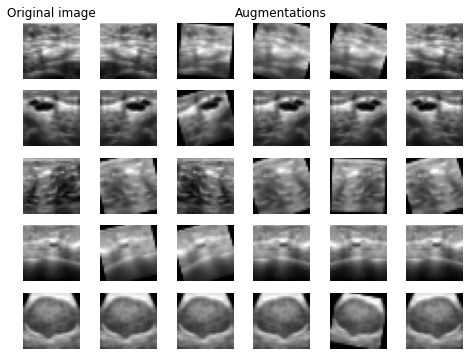

In [30]:
train_dataset = DataClass(split='train')
fig, axes = plt.subplots(5, 6, figsize=(8, 6))

for j in range(5):
    img, label = train_dataset[j]
    axes[j, 0].imshow(img, cmap='gray')
    axes[j, 0].axis('off')

    for i in range(1, 6):
        aug_img = data_aug_transform(img)
        axes[j, i].imshow(aug_img[0], cmap='gray')
        axes[j, i].axis('off')
  
axes[0, 0].set_title('Original image')
axes[0, 3].set_title('Augmentations')
plt.show()

100%|██████████| 400/400 [02:33<00:00,  2.60it/s]


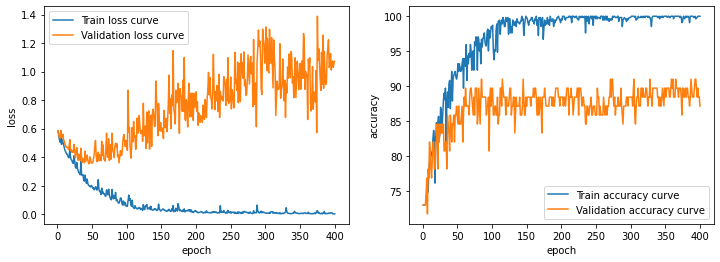

In [31]:
num_epochs = 400
lr = 5e-3
batch_size = 64
weight_decay = 1e-4

train_dataset = DataClass(split='train', transform=data_aug_transform)
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
train_eval_dataset = DataClass(split='train', transform=data_transform)
train_eval_loader = data.DataLoader(train_eval_dataset, batch_size=batch_size, shuffle=False)

model = get_model_with_dropout().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
criterion = nn.BCEWithLogitsLoss()

history = {'train_loss': [], 'train_acc': [], 
           'valid_loss': [], 'valid_acc': [],
           'test_loss': [], 'test_acc': [], 'step_loss': []}

for epoch in tqdm(range(1, num_epochs + 1)):
    train(model, train_loader)

    loss, acc = test(model, train_eval_loader)
    history['train_loss'].append(loss)
    history['train_acc'].append(acc)

    loss, acc = test(model, valid_loader)
    history['valid_loss'].append(loss)
    history['valid_acc'].append(acc)

    loss, acc = test(model, test_loader)
    history['test_loss'].append(loss)
    history['test_acc'].append(acc)

plot_curves(history)

In [32]:
early_stop_epoch = np.argmax(history['valid_acc'])
print('Train acc (Early stopping): %.2f' % history['train_acc'][early_stop_epoch])
print('Validation acc (Early stopping): %.2f' % history['valid_acc'][early_stop_epoch])
print('Test acc (Early stopping): %.2f' % history['test_acc'][early_stop_epoch])

Train acc (Early stopping): 96.70
Validation acc (Early stopping): 91.03
Test acc (Early stopping): 85.26
